# Building and Evaluating a ReAct Agent for Fetching Metal Prices

AI agents are becoming increasingly valuable in domains like finance, e-commerce, and customer support. These agents can autonomously interact with APIs, retrieve real-time data, and perform tasks that align with user goals. Evaluating these agents is crucial to ensure they are effective, accurate, and responsive to different inputs.

In this tutorial, we'll:

1. Build a [ReAct agent](https://arxiv.org/abs/2210.03629) to fetch metal prices.
2. Set up an evaluation pipeline to track key performance metrics.
3. Run and assess the agent's effectiveness with different queries.

Click the [link](https://colab.research.google.com/github/explodinggradients/ragas/blob/main/docs/howtos/integrations/langgraph_agent_evaluation.ipynb) to open the notebook in Google Colab.

## Prerequisites
- Python 3.8+
- Basic understanding of LangGraph, LangChain and LLMs

## Installing Ragas and Other Dependencies
Install Ragas and Langgraph with pip:

In [ ]:
%pip install langgraph==0.2.44
%pip install ragas
%pip install nltk

## Building the ReAct Agent

### Initializing External Components
To begin, you have two options for setting up the external components:

1. Use a Live API Key:  

    - Sign up for an account on [metals.dev](https://metals.dev/) to get your API key.  
    
2. Simulate the API Response:  

    - Alternatively, you can use a predefined JSON object to simulate the API response. This allows you to get started more quickly without needing a live API key.  


Choose the method that best fits your needs to proceed with the setup.

### Predefined JSON Object to simulate API response
If you would like to quickly get started without creating an account, you can bypass the setup process and use the predefined JSON object given below that simulates the API response.

In [1]:
metal_price = {
    "gold": 88.1553,
    "silver": 1.0523,
    "platinum": 32.169,
    "palladium": 35.8252,
    "lbma_gold_am": 88.3294,
    "lbma_gold_pm": 88.2313,
    "lbma_silver": 1.0545,
    "lbma_platinum_am": 31.99,
    "lbma_platinum_pm": 32.2793,
    "lbma_palladium_am": 36.0088,
    "lbma_palladium_pm": 36.2017,
    "mcx_gold": 93.2689,
    "mcx_gold_am": 94.281,
    "mcx_gold_pm": 94.1764,
    "mcx_silver": 1.125,
    "mcx_silver_am": 1.1501,
    "mcx_silver_pm": 1.1483,
    "ibja_gold": 93.2713,
    "copper": 0.0098,
    "aluminum": 0.0026,
    "lead": 0.0021,
    "nickel": 0.0159,
    "zinc": 0.0031,
    "lme_copper": 0.0096,
    "lme_aluminum": 0.0026,
    "lme_lead": 0.002,
    "lme_nickel": 0.0158,
    "lme_zinc": 0.0031,
}

### Define the get_metal_price Tool

The get_metal_price tool will be used by the agent to fetch the price of a specified metal. We'll create this tool using the @tool decorator from LangChain.

If you want to use real-time data from the metals.dev API, you can modify the function to make a live request to the API.

In [2]:
from langchain_core.tools import tool


# Define the tools for the agent to use
@tool
def get_metal_price(metal_name: str) -> float:
    """Fetches the current per gram price of the specified metal.

    Args:
        metal_name : The name of the metal (e.g., 'gold', 'silver', 'platinum').

    Returns:
        float: The current price of the metal in dollars per gram.

    Raises:
        KeyError: If the specified metal is not found in the data source.
    """
    try:
        metal_name = metal_name.lower().strip()
        if metal_name not in metal_price:
            raise KeyError(
                f"Metal '{metal_name}' not found. Available metals: {', '.join(metal_price['metals'].keys())}"
            )
        return metal_price[metal_name]
    except Exception as e:
        raise Exception(f"Error fetching metal price: {str(e)}")

### Binding the Tool to the LLM
With the get_metal_price tool defined, the next step is to bind it to the ChatOpenAI model. This enables the agent to invoke the tool during its execution based on the user's requests allowing it to interact with external data and perform actions beyond its native capabilities.

In [3]:
from langchain_openai import ChatOpenAI

tools = [get_metal_price]
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

In LangGraph, state plays a crucial role in tracking and updating information as the graph executes. As different parts of the graph run, the state evolves to reflect the changes and contains information that is passed between nodes.

For example, in a conversational system like this one, the state is used to track the exchanged messages. Each time a new message is generated, it is added to the state and the updated state is passed through the nodes, ensuring the conversation progresses logically.

### Defining the State
To implement this in LangGraph, we define a state class that maintains a list of messages. Whenever a new message is produced it gets appended to this list, ensuring that the conversation history is continuously updated.

In [4]:
from langgraph.graph import END
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

### Defining the should_continue Function
The `should_continue` function determines whether the conversation should proceed with further tool interactions or end. Specifically, it checks if the last message contains any tool calls (e.g., a request for metal prices).

- If the last message includes tool calls, indicating that the agent has invoked an external tool, the conversation continues and moves to the "tools" node.
- If there are no tool calls, the conversation ends, represented by the END state.

In [5]:
# Define the function that determines whether to continue or not
def should_continue(state: GraphState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

### Calling the Model
The `call_model` function interacts with the Language Model (LLM) to generate a response based on the current state of the conversation. It takes the updated state as input, processes it and returns a model-generated response.

In [6]:
# Define the function that calls the model
def call_model(state: GraphState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

### Creating the Assistant Node
The `assistant` node is a key component responsible for processing the current state of the conversation and using the Language Model (LLM) to generate a relevant response. It evaluates the state, determines the appropriate course of action, and invokes the LLM to produce a response that aligns with the ongoing dialogue.

In [7]:
# Node
def assistant(state: GraphState):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

### Creating the Tool Node
The `tool_node` is responsible for managing interactions with external tools, such as fetching metal prices or performing other actions beyond the LLM's native capabilities. The tools themselves are defined earlier in the code, and the tool_node invokes these tools based on the current state and the needs of the conversation.

In [8]:
from langgraph.prebuilt import ToolNode

# Node
tools = [get_metal_price]
tool_node = ToolNode(tools)

### Building the Graph
The graph structure is the backbone of the agentic workflow, consisting of interconnected nodes and edges. To construct this graph, we use the StateGraph builder which allows us to define and connect various nodes. Each node represents a step in the process (e.g., the assistant node, tool node) and the edges dictate the flow of execution between these steps.

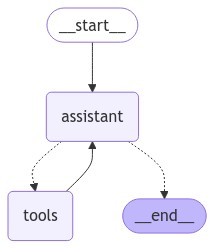

In [9]:
from langgraph.graph import START, StateGraph
from IPython.display import Image, display

# Define a new graph for the agent
builder = StateGraph(GraphState)

# Define the two nodes we will cycle between
builder.add_node("assistant", assistant)
builder.add_node("tools", tool_node)

# Set the entrypoint as `agent`
builder.add_edge(START, "assistant")

# Making a conditional edge
# should_continue will determine which node is called next.
builder.add_conditional_edges("assistant", should_continue, ["tools", END])

# Making a normal edge from `tools` to `agent`.
# The `agent` node will be called after the `tool`.
builder.add_edge("tools", "assistant")

# Compile and display the graph for a visual overview
react_graph = builder.compile()
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

To test our setup, we will run the agent with a query. The agent will fetch the price of copper using the metals.dev API.

In [10]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="What is the price of copper?")]
result = react_graph.invoke({"messages": messages})

In [11]:
result["messages"]

[HumanMessage(content='What is the price of copper?', id='4122f5d4-e298-49e8-a0e0-c98adda78c6c'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_DkVQBK4UMgiXrpguUS2qC4mA', 'function': {'arguments': '{"metal_name":"copper"}', 'name': 'get_metal_price'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 116, 'total_tokens': 134, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0f77b156-e43e-4c1e-bd3a-307333eefb68-0', tool_calls=[{'name': 'get_metal_price', 'args': {'metal_name': 'copper'}, 'id': 'call_DkVQBK4UMgiXrpguUS2qC4mA', 'type': 'tool_call'}], usage_metadata={'input_tokens': 116, 'output_tokens': 18, 'total_tokens': 134}

### Converting Messages to Ragas Evaluation Format

In the current implementation, the GraphState stores messages exchanged between the human user, the AI (LLM's responses), and any external tools (APIs or services the AI uses) in a list. Each message is an object in LangChain's format

```python
# Implementation of Graph State
class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
```

Each time a message is exchanged during agent execution, it gets added to the messages list in the GraphState. However, Ragas requires a specific message format for evaluating interactions.

Ragas uses its own format to evaluate agent interactions. So, if you're using LangGraph, you will need to convert the LangChain message objects into Ragas message objects. This allows you to evaluate your AI agents with Ragas’ built-in evaluation tools.

**Goal:**  Convert the list of LangChain messages (e.g., HumanMessage, AIMessage, and ToolMessage) into the format expected by Ragas, so the evaluation framework can understand and process them properly.

To convert a list of LangChain messages into a format suitable for Ragas evaluation, Ragas provides the function [convert_to_ragas_messages][ragas.integrations.langgraph.convert_to_ragas_messages], which can be used to transform LangChain messages into the format expected by Ragas.

Here's how you can use the function:

In [12]:
from ragas.integrations.langgraph import convert_to_ragas_messages

# Assuming 'result["messages"]' contains the list of LangChain messages
ragas_trace = convert_to_ragas_messages(result["messages"])

In [13]:
ragas_trace  # List of Ragas messages

[HumanMessage(content='What is the price of copper?', metadata=None, type='human'),
 AIMessage(content='', metadata=None, type='ai', tool_calls=[ToolCall(name='get_metal_price', args={'metal_name': 'copper'})]),
 ToolMessage(content='0.0098', metadata=None, type='tool'),
 AIMessage(content='The price of copper is $0.0098 per gram.', metadata=None, type='ai', tool_calls=None)]

## Evaluating the Agent's Performance

For this tutorial, let us evaluate the Agent with the following metrics:

- [Tool call Accuracy](https://docs.ragas.io/en/stable/concepts/metrics/available_metrics/agents/#tool-call-accuracy):ToolCallAccuracy is a metric that can be used to evaluate the performance of the LLM in identifying and calling the required tools to complete a given task.  

- [Agent Goal accuracy](https://docs.ragas.io/en/stable/concepts/metrics/available_metrics/agents/#agent-goal-accuracy): Agent goal accuracy is a metric that can be used to evaluate the performance of the LLM in identifying and achieving the goals of the user. This is a binary metric, with 1 indicating that the AI has achieved the goal and 0 indicating that the AI has not achieved the goal.


First, let us actually run our Agent with a couple of queries, and make sure we have the ground truth labels for these queries.

### Tool Call Accuracy

In [14]:
from ragas.metrics import ToolCallAccuracy
from ragas.dataset_schema import MultiTurnSample
from ragas.integrations.langgraph import convert_to_ragas_messages
import ragas.messages as r


ragas_trace = convert_to_ragas_messages(
    messages=result["messages"]
)  # List of Ragas messages converted using the Ragas function

sample = MultiTurnSample(
    user_input=ragas_trace,
    reference_tool_calls=[
        r.ToolCall(name="get_metal_price", args={"metal_name": "copper"})
    ],
)

tool_accuracy_scorer = ToolCallAccuracy()
tool_accuracy_scorer.llm = ChatOpenAI(model="gpt-4o-mini")
await tool_accuracy_scorer.multi_turn_ascore(sample)

1.0

Tool Call Accuracy: 1, because the LLM correctly identified and used the necessary tool (get_metal_price) with the correct parameters (i.e., metal name as "copper").

### Agent Goal Accuracy

In [15]:
messages = [HumanMessage(content="What is the price of 10 grams of silver?")]

result = react_graph.invoke({"messages": messages})

In [16]:
result["messages"]  # List of Langchain messages

[HumanMessage(content='What is the price of 10 grams of silver?', id='51a469de-5b7c-4d01-ab71-f8db64c8da49'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rdplOo95CRwo3mZcPu4dmNxG', 'function': {'arguments': '{"metal_name":"silver"}', 'name': 'get_metal_price'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 120, 'total_tokens': 137, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3bb60e27-1275-41f1-a46e-03f77984c9d8-0', tool_calls=[{'name': 'get_metal_price', 'args': {'metal_name': 'silver'}, 'id': 'call_rdplOo95CRwo3mZcPu4dmNxG', 'type': 'tool_call'}], usage_metadata={'input_tokens': 120, 'output_tokens': 17, 'total_t

In [17]:
from ragas.integrations.langgraph import convert_to_ragas_messages

ragas_trace = convert_to_ragas_messages(
    result["messages"]
)  # List of Ragas messages converted using the Ragas function
ragas_trace

[HumanMessage(content='What is the price of 10 grams of silver?', metadata=None, type='human'),
 AIMessage(content='', metadata=None, type='ai', tool_calls=[ToolCall(name='get_metal_price', args={'metal_name': 'silver'})]),
 ToolMessage(content='1.0523', metadata=None, type='tool'),
 AIMessage(content='The current price of silver is approximately $1.0523 per gram. Therefore, the price of 10 grams of silver would be about $10.52.', metadata=None, type='ai', tool_calls=None)]

In [18]:
from ragas.dataset_schema import MultiTurnSample
from ragas.metrics import AgentGoalAccuracyWithReference
from ragas.llms import LangchainLLMWrapper


sample = MultiTurnSample(
    user_input=ragas_trace,
    reference="Price of 10 grams of silver",
)

scorer = AgentGoalAccuracyWithReference()

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini"))
scorer.llm = evaluator_llm
await scorer.multi_turn_ascore(sample)

1.0

Agent Goal Accuracy: 1, because the LLM correctly achieved the user’s goal of retrieving the price of 10 grams of silver.

## What’s next
🎉 Congratulations! We have learned how to evaluate an agent using the Ragas evaluation framework.